In [1]:
import pandas as pd
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.exceptions import ConvergenceWarning
from tqdm import tqdm, tqdm_notebook

# Preprocessing

### Import Dataset

In [2]:
df = pd.read_csv(
    "../Datasets/Raw_Data/GSE221521_gene_expression.csv", index_col=1)
df.head()

gene_id  \
gene_name                     
AC073488.4  ENSG00000282222   
AC119427.1  ENSG00000282221   
MIR543      ENSG00000212040   
MADD        ENSG00000110514   
AL356737.2  ENSG00000287159   

                                                  description  \
gene_name                                                       
AC073488.4  chromodomain protein, Y chromosome-like (CDYL)...   
AC119427.1                novel transcript, antisense to LAD1   
MIR543       microRNA 543 [Source:HGNC Symbol;Acc:HGNC:33664]   
MADD        MAP kinase activating death domain [Source:HGN...   
AL356737.2                novel transcript, antisense to GPC5   

                       gene_type                   locus  RNA1_FPKM  \
gene_name                                                             
AC073488.4  processed_pseudogene       X:9410789-9411545   0.000000   
AC119427.1                lncRNA   1:201399633-201401190   0.000000   
MIR543                     miRNA  14:101031987-101032064   0.000000   
MADD              protein_coding    11:47269161-47330031   6.345943   
AL356737.2                lncRNA    13:92610646-92677725   0.000000   

            RNA102_FPKM  RNA104_FPKM  RNA108_FPKM  RNA109_FPKM  RNA110_FPKM  \
gene_name                                                                     
AC073488.4     0.000000     0.000000     0.000000     0.000000     0.000000   
AC119427.1     0.000000     0.000000     0.000000     0.000000     0.000000   
MIR543         0.000000     0.000000     0.000000     0.000000     0.962816   
MADD           8.482109    10.209322     7.143557     5.671481     7.776351   
AL356737.2     0.000000     0.000000     0.000000     0.000000     0.000000   

            ...  R_JS032_count  R_JS033_count  R_JS034_count  R_JS035_count  \
gene_name   ...                                                               
AC073488.4  ...              0              0              0              0   
AC119427.1  ...              0              0              0              0   
MIR543      ...              0              0              0              0   
MADD        ...           1187           1254           1767           1184   
AL356737.2  ...              0              0              0              0   

            R_JS036_count  R_JS037_count  R_JS038_count  R_JS039_count  \
gene_name                                                                
AC073488.4              0              0              1              0   
AC119427.1              0              0              0              0   
MIR543                  0              0              0              0   
MADD                 2418           1294           1254           1461   
AL356737.2              0              0              0              0   

            R_JS040_count  R_JS041_count  
gene_name                                 
AC073488.4              0              0  
AC119427.1              0              0  
MIR543                  0              0  
MADD                 1323           1795  
AL356737.2              0              0  

[5 rows x 390 columns]

### Check Gene Types

In [3]:
df['gene_type'].value_counts()

protein_coding                        19973
lncRNA                                16889
processed_pseudogene                  10162
unprocessed_pseudogene                 2612
misc_RNA                               2220
snRNA                                  1910
miRNA                                  1879
TEC                                    1057
snoRNA                                  943
transcribed_unprocessed_pseudogene      938
transcribed_processed_pseudogene        500
rRNA_pseudogene                         496
IG_V_pseudogene                         187
IG_V_gene                               145
transcribed_unitary_pseudogene          138
TR_V_gene                               106
unitary_pseudogene                       98
TR_J_gene                                79
rRNA                                     53
scaRNA                                   49
polymorphic_pseudogene                   48
IG_D_gene                                37
TR_V_pseudogene                 

### Transform the Dataset

In [4]:
df = df[df['gene_type'] == 'miRNA']
df = df.drop(['gene_type', 'description', 'gene_id', 'locus'], axis=1)
df = df.iloc[:, :193]
df = df.T
df.to_csv('../Datasets/Dataset11/data0.csv')

### Combine with Diagnosis

In [5]:
df = pd.read_csv('../Datasets/Dataset11/data0.csv', index_col=0)
diagnosis = pd.read_csv("../Datasets/Dataset05/Diagnosis.csv", index_col=0)
df['Diagnosis'] = diagnosis['Diagnosis']
df.to_csv('../Datasets/Dataset11/data1.csv')

df.head()

MIR543  MIR2392  MIR3915   MIR6726    MIR2277   MIR4651  \
RNA1_FPKM       0.0      0.0      0.0  1.302332   0.854218  1.088250   
RNA102_FPKM     0.0      0.0      0.0  1.235294  10.534753  1.032232   
RNA104_FPKM     0.0      0.0      0.0  1.213825   8.756105  0.000000   
RNA108_FPKM     0.0      0.0      0.0  0.000000   0.864373  0.000000   
RNA109_FPKM     0.0      0.0      0.0  0.000000   0.860180  1.095845   

             MIR1302-2   MIR4741    MIR6891  MIR6724-3  ...    MIR553  \
RNA1_FPKM          0.0  0.882692  15.375925        0.0  ...  1.168269   
RNA102_FPKM        0.0  0.837255  11.345000        0.0  ...  0.000000   
RNA104_FPKM        0.0  0.822704   1.592330        0.0  ...  1.088873   
RNA108_FPKM        0.0  0.893185   7.781817        0.0  ...  1.182157   
RNA109_FPKM        0.0  0.888852  63.625791        0.0  ...  1.176422   

             MIR199A1  MIR3689D2  MIR4438  MIR5702   MIR378H  MIR1283-1  \
RNA1_FPKM    1.118905        0.0      0.0      0.0  0.000000        0.0   
RNA102_FPKM  2.122618        0.0      0.0      0.0  0.000000        0.0   
RNA104_FPKM  2.085728        0.0      0.0      0.0  0.000000        0.0   
RNA108_FPKM  1.132207        0.0      0.0      0.0  0.968514        0.0   
RNA109_FPKM  2.252303        0.0      0.0      0.0  0.000000        0.0   

             MIR3621   MIR1227  Diagnosis  
RNA1_FPKM        0.0  1.805506          1  
RNA102_FPKM      0.0  0.856283          2  
RNA104_FPKM      0.0  0.841402          1  
RNA108_FPKM      0.0  0.913485          1  
RNA109_FPKM      0.0  0.909053          0  

[5 rows x 1880 columns]

### Remove Patients who hasn't Diabetic

In [6]:
df = pd.read_csv('../Datasets/Dataset11/data1.csv', index_col=0)
df = df[df['Diagnosis'] != 0]
df['Diagnosis'] = df['Diagnosis'] - 1
df.to_csv("../Datasets/Dataset11/data2.csv")
df.head()

MIR543  MIR2392  MIR3915   MIR6726    MIR2277   MIR4651  \
RNA1_FPKM    0.000000      0.0      0.0  1.302332   0.854218  1.088250   
RNA102_FPKM  0.000000      0.0      0.0  1.235294  10.534753  1.032232   
RNA104_FPKM  0.000000      0.0      0.0  1.213825   8.756105  0.000000   
RNA108_FPKM  0.000000      0.0      0.0  0.000000   0.864373  0.000000   
RNA110_FPKM  0.962816      0.0      0.0  1.231142   0.807523  0.000000   

             MIR1302-2   MIR4741    MIR6891  MIR6724-3  ...    MIR553  \
RNA1_FPKM          0.0  0.882692  15.375925        0.0  ...  1.168269   
RNA102_FPKM        0.0  0.837255  11.345000        0.0  ...  0.000000   
RNA104_FPKM        0.0  0.822704   1.592330        0.0  ...  1.088873   
RNA108_FPKM        0.0  0.893185   7.781817        0.0  ...  1.182157   
RNA110_FPKM        0.0  0.834441   8.076697        0.0  ...  1.104407   

             MIR199A1  MIR3689D2  MIR4438  MIR5702   MIR378H  MIR1283-1  \
RNA1_FPKM    1.118905        0.0      0.0      0.0  0.000000        0.0   
RNA102_FPKM  2.122618        0.0      0.0      0.0  0.000000        0.0   
RNA104_FPKM  2.085728        0.0      0.0      0.0  0.000000        0.0   
RNA108_FPKM  1.132207        0.0      0.0      0.0  0.968514        0.0   
RNA110_FPKM  1.057742        0.0      0.0      0.0  0.000000        0.0   

             MIR3621   MIR1227  Diagnosis  
RNA1_FPKM        0.0  1.805506          0  
RNA102_FPKM      0.0  0.856283          1  
RNA104_FPKM      0.0  0.841402          0  
RNA108_FPKM      0.0  0.913485          0  
RNA110_FPKM      0.0  2.560990          0  

[5 rows x 1880 columns]

### Analyze the Dataset

In [7]:
df = pd.read_csv("../Datasets/Dataset11/data2.csv", index_col=0)
df.describe()

MIR543  MIR2392  MIR3915     MIR6726     MIR2277     MIR4651  \
count  143.000000    143.0    143.0  143.000000  143.000000  143.000000   
mean     0.050020      0.0      0.0    1.215367    2.495901    0.622330   
std      0.255134      0.0      0.0    0.886367    3.777734    0.580837   
min      0.000000      0.0      0.0    0.000000    0.000000    0.000000   
25%      0.000000      0.0      0.0    0.935465    0.808973    0.000000   
50%      0.000000      0.0      0.0    1.277188    0.872861    0.917568   
75%      0.000000      0.0      0.0    1.406536    1.022052    1.095376   
max      2.132094      0.0      0.0    5.095619   20.052811    2.197755   

        MIR1302-2     MIR4741     MIR6891  MIR6724-3  ...      MIR553  \
count  143.000000  143.000000  143.000000      143.0  ...  143.000000   
mean     0.030281    0.754734   47.809112        0.0  ...    1.097940   
std      0.157941    0.356245   79.852570        0.0  ...    0.997279   
min      0.000000    0.000000    0.000000        0.0  ...    0.000000   
25%      0.000000    0.741744    5.455548        0.0  ...    0.000000   
50%      0.000000    0.870113   14.563839        0.0  ...    1.137153   
75%      0.000000    0.930165   34.950920        0.0  ...    1.336982   
max      1.218849    1.782624  427.815286        0.0  ...    4.837578   

         MIR199A1  MIR3689D2  MIR4438  MIR5702     MIR378H  MIR1283-1  \
count  143.000000      143.0    143.0    143.0  143.000000      143.0   
mean     2.008079        0.0      0.0      0.0    0.223873        0.0   
std      1.272390        0.0      0.0      0.0    0.441905        0.0   
min      0.000000        0.0      0.0      0.0    0.000000        0.0   
25%      1.110572        0.0      0.0      0.0    0.000000        0.0   
50%      2.134810        0.0      0.0      0.0    0.000000        0.0   
75%      2.562243        0.0      0.0      0.0    0.000000        0.0   
max      8.390962        0.0      0.0      0.0    2.278532        0.0   

          MIR3621     MIR1227   Diagnosis  
count  143.000000  143.000000  143.000000  
mean     0.106050    1.313596    0.468531  
std      0.314606    0.713426    0.500763  
min      0.000000    0.000000    0.000000  
25%      0.000000    0.868264    0.000000  
50%      0.000000    0.965723    0.000000  
75%      0.000000    1.781082    1.000000  
max      1.959722    4.405731    1.000000  

[8 rows x 1880 columns]

In [8]:
df.dtypes

MIR543       float64
MIR2392      float64
MIR3915      float64
MIR6726      float64
MIR2277      float64
              ...   
MIR378H      float64
MIR1283-1    float64
MIR3621      float64
MIR1227      float64
Diagnosis      int64
Length: 1880, dtype: object

In [9]:
df.isnull().sum()

MIR543       0
MIR2392      0
MIR3915      0
MIR6726      0
MIR2277      0
            ..
MIR378H      0
MIR1283-1    0
MIR3621      0
MIR1227      0
Diagnosis    0
Length: 1880, dtype: int64

# Feature Selection

### Select best Feature Selection Algorithm

In [10]:
df = pd.read_csv("../Datasets/Dataset11/data2.csv", index_col=0)

features = df.drop('Diagnosis', axis=1)
target = df['Diagnosis']

result_df = pd.DataFrame(
    columns=['Feature Selection Algorithm', 'Feature Count', 'Cross Validation Score'])

feature_counts = [25, 50, 100, 150, 200]

feature_selection_algorithms = [
    ('Information Gain (Mutual info)', mutual_info_classif),
    ('Correlation Coefficient', f_classif),
    ('Chi-Square', chi2),
    ('Feature Importance', RandomForestClassifier().fit(
        features, target).feature_importances_)
]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for algo_name, algo_func in feature_selection_algorithms:
    for count in feature_counts:
        if algo_name == 'Feature Importance':
            selected_features = features.columns[algo_func.argsort(
            )[-count:][::-1]]
        else:
            selected_features = features.columns[algo_func(
                features, target)[0].argsort()[-count:][::-1]]

        clf = SVC(kernel='linear')
        cv_scores = cross_val_score(
            clf, features[selected_features], target, cv=cv)

        result_df = pd.concat([result_df, pd.DataFrame({
            'Feature Selection Algorithm': [algo_name],
            'Feature Count': [count],
            'Cross Validation Score': [f'{cv_scores.mean():.2f}+/-{cv_scores.std():.2f}']
        })], ignore_index=True)

print(result_df)

c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [   1    2    9   10   11   12   13   14   15   16   19   22   23   24
   28   31   35   39   66   67   72   74   75   77   79   80   81   86
   87   90   91   92   93   94   98  101  102  107  109  114  115  116
  122  123  124  130  137  142  147  148  154  155  157  162  163  164
  177  178  183  191  199  201  202  209  210  212  213  214  216  219
  221  227  233  234  235  236  239  240  243  245  249  250  253  261
  262  264  266  268  273  274  276  277  278  282  285  286  288  291
  297  298  299  300  302  308  309  310  313  316  322  329  331  332
  333  334  335  342  347  349  350  351  352  356  358  361  362  365
  366  368  370  372  373  375  376  378  384  385  387  389  392  393
  394  399  405  406  408  409  412  415  416  417  418  419  420  422
  435  436  440  445  446  450  451  452  453  456  457  460  461  463
  474  478  480  482  485  4

       Feature Selection Algorithm Feature Count Cross Validation Score
0   Information Gain (Mutual info)            25            0.53+/-0.09
1   Information Gain (Mutual info)            50            0.53+/-0.09
2   Information Gain (Mutual info)           100            0.53+/-0.09
3   Information Gain (Mutual info)           150            0.53+/-0.09
4   Information Gain (Mutual info)           200            0.53+/-0.09
5          Correlation Coefficient            25            0.53+/-0.09
6          Correlation Coefficient            50            0.53+/-0.09
7          Correlation Coefficient           100            0.53+/-0.09
8          Correlation Coefficient           150            0.53+/-0.09
9          Correlation Coefficient           200            0.53+/-0.09
10                      Chi-Square            25            0.53+/-0.09
11                      Chi-Square            50            0.53+/-0.09
12                      Chi-Square           100            0.53

### Check Feature Importance

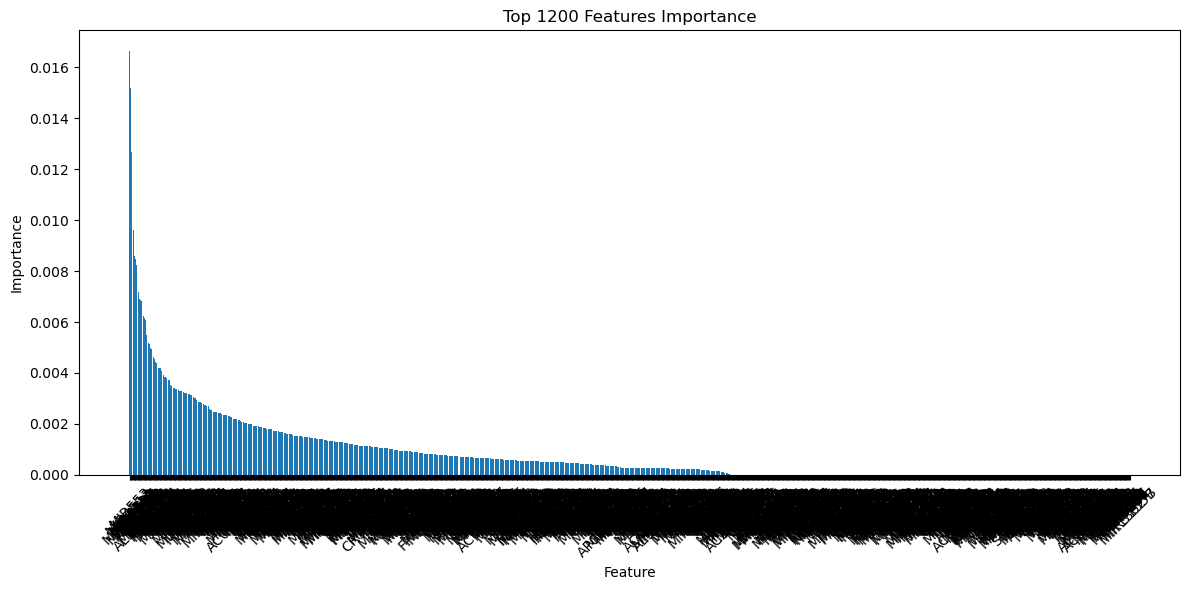

Last important feature:  722


In [11]:
df = pd.read_csv("../Datasets/Dataset11/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_names = X.columns

k_values = [1200]

selected_features_dict = {}

for k in k_values:
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)
    feature_importances = clf.feature_importances_
    selected_features = np.array(feature_names)[
        np.argsort(feature_importances)[::-1][:k]]

    selected_features_dict[k] = selected_features

    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title(f"Top {k} Features Importance")
    plt.bar(range(k), feature_importances[sorted_idx][:k], align="center")
    plt.xticks(range(k), np.array(feature_names)[sorted_idx][:k], rotation=45)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

    zero_importance_index = np.where(feature_importances == 0)[0]
    print("Last important feature: ", len(
        X.columns)-len(zero_importance_index))

### Feature Selection

In [12]:
df = pd.read_csv("../Datasets/Dataset11/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_counts = list(range(1, 144))

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

feature_importances = clf.feature_importances_

selected_features = X.columns[np.argsort(feature_importances)[::-1]]

datasets = {}
for count in feature_counts:
    datasets[count] = X[selected_features[:count]].copy()
    datasets[count]['Diagnosis'] = y

for count, dataset in datasets.items():
    dataset.to_csv(
        f'../Datasets/Dataset11/Feature_Select/dataset_{count}.csv', index=True)

## Model Building

### Check CV Score for Different Models

In [13]:
feature_counts = list(range(1, 144))

models = {
    "SVM(linear)": SVC(kernel='linear'),
    "SVM(poly)": SVC(kernel='poly'),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "ANN": MLPClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
}

results = pd.DataFrame(
    columns=["Model Name", "Feature Count", "CV Score (Mean +/- Std)"])

for count in tqdm(feature_counts, desc="Processing feature counts", unit=" feature counts", colour='green'):
    file_path = f"../Datasets/Dataset11/Feature_Select/dataset_{count}.csv"
    df = pd.read_csv(file_path, index_col=0)

    X = df.drop('Diagnosis', axis=1)
    y = df['Diagnosis']

    for model_name, model in models.items():
        cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        if model_name == "ANN":
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                scores = cross_val_score(model, X, y, cv=cv)
        elif model_name == "Logistic Regression": 
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                scores = cross_val_score(model, X, y, cv=cv)
        else:
            scores = cross_val_score(model, X, y, cv=cv)
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        result = f"{mean_score:.4f} +/- {std_score:.4f}"
        new_data = pd.DataFrame({"Model Name": [model_name],
                                 "Feature Count": [count],
                                 "CV Score (Mean +/- Std)": [result]})
        results = pd.concat([results, new_data], ignore_index=True)
        # print(f"{model_name} with {count} features: {result}")

results.sort_values(by=["CV Score (Mean +/- Std)"],
                    ascending=False, inplace=True)
results.to_csv("../Datasets/Dataset11/Feature_Select/results.csv", index=False)

Processing feature counts: 100%|██████████| 143/143 [13:54<00:00,  5.84s/ feature counts]


In [14]:
df = pd.read_csv("../Datasets/Dataset11/Feature_Select/results.csv")
df.head(10)

Model Name  Feature Count CV Score (Mean +/- Std)
0            ANN             95       0.7862 +/- 0.0828
1    Naive Bayes             31       0.7862 +/- 0.0402
2    Naive Bayes             30       0.7862 +/- 0.0402
3    Naive Bayes             28       0.7862 +/- 0.0258
4  Random Forest             96       0.7862 +/- 0.0258
5    Naive Bayes             37       0.7862 +/- 0.0258
6    Naive Bayes             36       0.7862 +/- 0.0258
7    Naive Bayes            137       0.7793 +/- 0.0468
8    Naive Bayes            135       0.7793 +/- 0.0468
9    Naive Bayes            132       0.7793 +/- 0.0468

### Check Distributions

In [17]:
feature_count = 36

data = pd.read_csv(
    f'../Datasets/Dataset11/Feature_Select/dataset_{feature_count}.csv')

target_column = data.columns[feature_count + 1]

num_rows = math.ceil(feature_count / 4)
num_columns = 4

fig, axes = plt.subplots(num_rows, num_columns, figsize=(80, 140))

for i in range(min(feature_count, num_rows * num_columns)):
    row_index = i // num_columns
    col_index = i % num_columns

    sns.histplot(
        data=data, x=data.columns[i + 1], hue=target_column, kde=True, ax=axes[row_index, col_index])

    axes[row_index, col_index].set_title(
        f'Distribution of {data.columns[i + 1]}')

    axes[row_index, col_index].set_xlabel(data.columns[i + 1])

    axes[row_index, col_index].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

### Check Accuracy

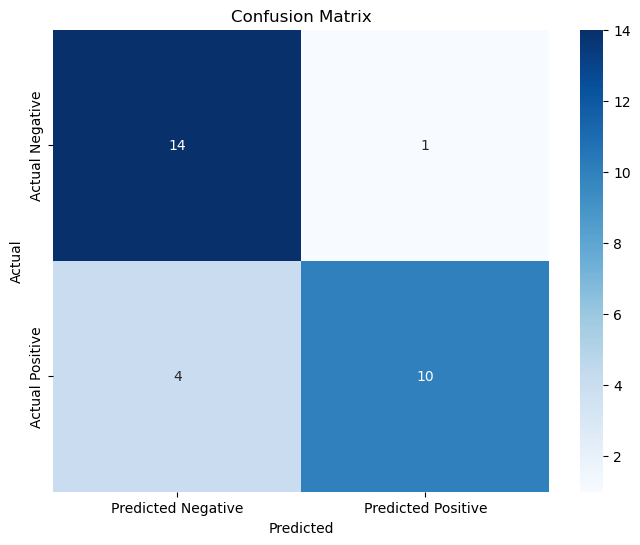

Accuracy: 0.83
Precision: 0.91
Recall (Sensitivity): 0.71
Specificity: 0.93
F1 Score: 0.80


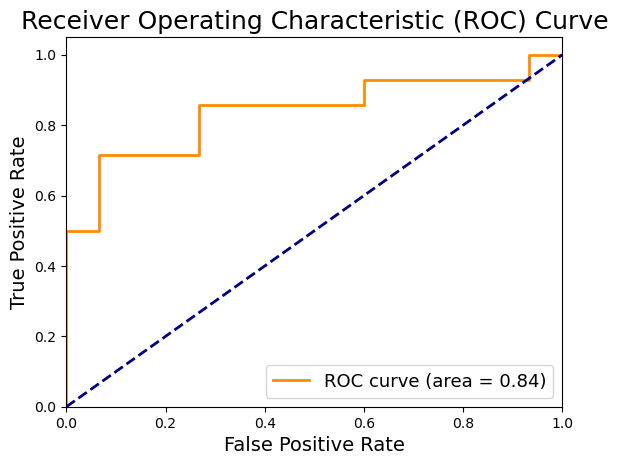

In [18]:
feature_count = 36

df = pd.read_csv(
    f'../Datasets/Dataset11/Feature_Select/dataset_{feature_count}.csv', index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

y_scores = clf.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1:.2f}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
plt.legend(loc='lower right', fontsize=13)
plt.show()